# Import

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import geopandas as gpd
from geopandas import GeoDataFrame
import seaborn as sns
import libpysal as lps
from libpysal.weights import Queen
import pysal as ps
import numpy as np
import pandas as pd
import pysal.viz as viz
import urllib
import zipfile
import mgwr
import mapclassify
import math
from libpysal.cg import shapely_ext
import scipy.spatial as spatial

import shapely.geometry
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.path as path
import matplotlib.pyplot as plt
%matplotlib inline

import esda
import spreg
from spreg import OLS
from spreg import ML_Error
from spreg import ML_Lag

import math

# GWR prediction libraries
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR
# from pysal.contrib.glm.family import Gaussian
from scipy.stats import pearsonr

import warnings
warnings.simplefilter('ignore')

Error in sys.excepthook:
Traceback (most recent call last):
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\interactiveshell.py", line 1934, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'UnicodeDecodeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\interactiveshell.py", line 1936, in showtraceback
    stb = self.InteractiveTB.structured_traceback(etype,
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\ultratb.py", line 1105, in structured_traceback
    return FormattedTB.structured_traceback(
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\ultratb.py", line 999, in structured_traceback
    return VerboseTB.structured_traceback(
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\c

# culture_site

In [2]:
#Read data
culture_site=pd.read_csv('data/all_sites.csv')

In [3]:
culture_site=culture_site.dropna(axis=0, subset=["latitude"])
culture_site=culture_site.dropna(axis=0, subset=["longitude"])

<AxesSubplot:>

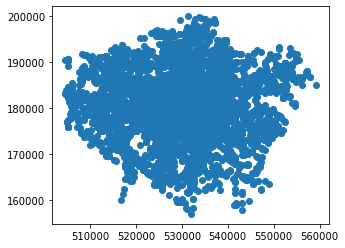

In [4]:
#Visualising cultural infrastructure location points
geometry = [Point(xy) for xy in zip(culture_site.longitude, culture_site.latitude)]
culture_site.drop(['longitude', 'latitude'], axis=1, inplace=True)
crs = {'init': 'epsg:4326'}
culture_site = gpd.GeoDataFrame(culture_site, crs=crs, geometry=geometry)
culture_site = culture_site.to_crs({'init': 'epsg:27700'})
culture_site.plot()

In [5]:
culture_site.columns

Index(['BOROUGH', 'Cultural Venue Type', 'additional_contact_name', 'address1',
       'address2', 'address3', 'alternativenames', 'borough_code',
       'borough_name', 'building_name', 'contact_name', 'easting',
       'fid_london_ward', 'greenflagcommunityaward', 'gss_code', 'northing',
       'os_addressbase_uprn', 'rm_organisation_name', 'runtime', 'site_name',
       'ward', 'ward_2018_code', 'ward_2018_name', 'ward_code',
       'ward_code_2018', 'ward_name_2018', 'website', 'geometry'],
      dtype='object')

# lsoa

In [6]:
#read data
lsoas=gpd.read_file('data/LSOA_IMD2019.shp')

Error in sys.excepthook:
Traceback (most recent call last):
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\interactiveshell.py", line 1934, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'UnicodeDecodeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\interactiveshell.py", line 1936, in showtraceback
    stb = self.InteractiveTB.structured_traceback(etype,
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\ultratb.py", line 1105, in structured_traceback
    return FormattedTB.structured_traceback(
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\ultratb.py", line 999, in structured_traceback
    return VerboseTB.structured_traceback(
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\c

In [7]:
lsoa = lsoas.to_crs({'init': 'epsg:27700'})

In [8]:
lsoa

LSOA11CD                   LSOA11NM   MSOA11CD  \
0     E01000001        City of London 001A  E02000001   
1     E01000002        City of London 001B  E02000001   
2     E01000003        City of London 001C  E02000001   
3     E01000005        City of London 001E  E02000001   
4     E01000006  Barking and Dagenham 016A  E02000017   
...         ...                        ...        ...   
4830  E01033742             Greenwich 007F  E02000319   
4831  E01033743             Greenwich 002H  E02000314   
4832  E01033744             Greenwich 007G  E02000319   
4833  E01033745             Greenwich 002I  E02000314   
4834  E01033746             Greenwich 038E  E02006931   

                      MSOA11NM    LAD11CD               LAD11NM    RGN11CD  \
0           City of London 001  E09000001        City of London  E12000007   
1           City of London 001  E09000001        City of London  E12000007   
2           City of London 001  E09000001        City of London  E12000007   
3           City of London 001  E09000001        City of London  E12000007   
4     Barking and Dagenham 016  E09000002  Barking and Dagenham  E12000007   
...                        ...        ...                   ...        ...   
4830             Greenwich 007  E09000011             Greenwich  E12000007   
4831             Greenwich 002  E09000011             Greenwich  E12000007   
4832             Greenwich 007  E09000011             Greenwich  E12000007   
4833             Greenwich 002  E09000011             Greenwich  E12000007   
4834             Greenwich 038  E09000011             Greenwich  E12000007   

     RGN11NM  USUALRES  HHOLDRES  ...  IMD2019_Cr  IMD2019_14  IMD2019_15  \
0     London      1465      1465  ...        -2.0       32662          10   
1     London      1436      1436  ...        -2.3       32789          10   
2     London      1346      1250  ...        -1.0       29363           9   
3     London       985       985  ...        -1.3       31059          10   
4     London      1703      1699  ...        -0.1       18848           6   
...      ...       ...       ...  ...         ...         ...         ...   
4830  London      1352      1352  ...        -0.2       19491           6   
4831  London      2038      2038  ...         0.2       13267           5   
4832  London      1845      1728  ...         0.4       10943           4   
4833  London      1820      1820  ...        -0.3       20703           7   
4834  London      1464      1436  ...         0.7        6747           3   

      IMD2019_Ba IMD2019_16 IMD2019_17 IMD2019_Li IMD2019_18  IMD2019_19  \
0           29.5       7319          3       31.9       7789           3   
1           24.4      11707          4       23.1      13070           4   
2           40.1       2157          1       40.5       4092           2   
3           39.9       2217          1       29.0       9397           3   
4           45.2       1033          1       26.9      10629           4   
...          ...        ...        ...        ...        ...         ...   
4830        40.5       2042          1       12.5      21492           7   
4831        50.3        286          1       11.9      22054           7   
4832        37.3       3095          1       14.2      19969           7   
4833        45.1       1047          1       14.8      19362           6   
4834        24.0      12146          4       45.7       2734           1   

                                               geometry  
0     POLYGON ((532105.092 182011.230, 532162.491 18...  
1     POLYGON ((532746.813 181786.891, 532671.688 18...  
2     POLYGON ((532135.145 182198.119, 532158.250 18...  
3     POLYGON ((533807.946 180767.770, 533649.063 18...  
4     POLYGON ((545122.049 184314.931, 545271.917 18...  
...                                                 ...  
4830  POLYGON ((544642.680 179824.674, 544766.313 17...  
4831  POLYGON ((546579.195 181097.813, 546687.036 18...  
4832  POLYGON ((544536.48

In [9]:
lsoa.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [10]:
#Merging two dataframe
df_cs = gpd.sjoin(culture_site, lsoas, how="inner", op='within')

In [11]:
df_cs.columns

Index(['BOROUGH', 'Cultural Venue Type', 'additional_contact_name', 'address1',
       'address2', 'address3', 'alternativenames', 'borough_code',
       'borough_name', 'building_name', 'contact_name', 'easting',
       'fid_london_ward', 'greenflagcommunityaward', 'gss_code', 'northing',
       'os_addressbase_uprn', 'rm_organisation_name', 'runtime', 'site_name',
       'ward', 'ward_2018_code', 'ward_2018_name', 'ward_code',
       'ward_code_2018', 'ward_name_2018', 'website', 'geometry',
       'index_right', 'LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM',
       'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES',
       'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ', 'IMD2019_LS',
       'IMD2019__1', 'IMD2019_Lo', 'IMD2019__2', 'IMD2019_In', 'IMD2019__3',
       'IMD2019__4', 'IMD2019__5', 'IMD2019__6', 'IMD2019__7', 'IMD2019_Em',
       'IMD2019__8', 'IMD2019__9', 'IMD2019_Ed', 'IMD2019_10', 'IMD2019_11',
       'IMD2019_He', 'IMD2019_12', 'IMD2019_13', 'IMD2019_

In [12]:
num_cs=df_cs.LSOA11CD.value_counts() 

In [13]:
num_cs=num_cs.reset_index()

In [14]:
num_cs

index  LSOA11CD
0     E01032739       208
1     E01004736       127
2     E01004763       127
3     E01004734       118
4     E01033595       114
...         ...       ...
2712  E01001220         1
2713  E01001287         1
2714  E01001244         1
2715  E01001330         1
2716  E01002148         1

[2717 rows x 2 columns]

In [15]:
num_cs.rename(columns={'index':'LSOA', 'LSOA11CD':'num_cs'}, inplace = True)
num_cs

LSOA  num_cs
0     E01032739     208
1     E01004736     127
2     E01004763     127
3     E01004734     118
4     E01033595     114
...         ...     ...
2712  E01001220       1
2713  E01001287       1
2714  E01001244       1
2715  E01001330       1
2716  E01002148       1

[2717 rows x 2 columns]

In [16]:
lsoa['num_cs']=lsoa['LSOA11CD'].apply(lambda x:  num_cs[num_cs['LSOA']==x]['num_cs'].values.tolist()[0]if num_cs[num_cs['LSOA']==x]['num_cs'].values.tolist()!=[] else 0 )

In [17]:
lsoa.drop(['MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 
           'IMD2019_LS', 'IMD2019__1', 'IMD2019_Lo', 'IMD2019__2', 'IMD2019__3', 'IMD2019__4',
           'IMD2019__6', 'IMD2019__7', 'IMD2019__8', 'IMD2019__9', 'IMD2019_10', 'IMD2019_11',
           'IMD2019_12', 'IMD2019_13', 'IMD2019_14', 'IMD2019_15', 'IMD2019_16', 'IMD2019_17',
           'IMD2019_18', 'IMD2019_19','IMD2019_Ba','IMD2019_Em','IMD2019_Cr','LSOA11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ'], axis=1, inplace=True)

In [18]:
lsoa.rename(columns={'IMD2019_In':'IMD_index', 'IMD2019__5':'Income', 'IMD2019_Ed':'Education',
                    'IMD2019_He':'Health','IMD2019_Li':'Environmrnt'}, inplace=True)

In [19]:
lsoa.columns

Index(['LSOA11CD', 'IMD_index', 'Income', 'Education', 'Health', 'Environmrnt',
       'geometry', 'num_cs'],
      dtype='object')

# crime_num

In [20]:
#read data
crime=pd.read_csv('data/MPS LSOA Level Crime (most recent 24 months).csv')

In [21]:
crime_num=crime.columns.tolist()
del crime_num[0:5]

In [22]:
crime['sum_crime']=0
for i in crime_num:
    crime['sum_crime']=crime['sum_crime']+crime[i]
crime['sum_crime']

0          2
1          9
2          1
3          9
4          3
          ..
103081     1
103082    21
103083     8
103084     7
103085    22
Name: sum_crime, Length: 103086, dtype: int64

In [23]:
crime=crime[['LSOA Code','sum_crime']]

In [24]:
new_crime=crime.groupby(['LSOA Code'],as_index=False)["sum_crime"].apply(sum)

In [25]:
lsoa['num_crime']=lsoa['LSOA11CD'].apply(lambda x:  new_crime[new_crime['LSOA Code']==x]['sum_crime'].values.tolist()[0]if new_crime[new_crime['LSOA Code']==x]['sum_crime'].values.tolist()!=[] else 0 )

In [26]:
#Take logarithm
lsoa['num_crime']=lsoa['num_crime'].apply(lambda x: math.log(x) if x!=0 else 0)

# polulation_density

In [27]:
#read data
p_density=pd.read_csv('data/land-area-population-density-lsoa11-msoa11.csv')

In [28]:
p_density[['LSOA11 Code','People per Sq Km']]

LSOA11 Code People per Sq Km
0      E01000001           11,656
1      E01000002            6,664
2      E01000003           23,198
3      E01000005            7,152
4      E01032739              649
...          ...              ...
4830   E01001638           19,954
4831   E01001641            4,703
4832   E01001642            1,444
4833   E01001644           11,894
4834   E01033746           10,850

[4835 rows x 2 columns]

In [29]:
p_density['People per Sq Km']=p_density['People per Sq Km'].apply(lambda x: x.replace(',',''))

In [30]:
p_density['People per Sq Km']=p_density['People per Sq Km'].astype(float)

In [31]:
lsoa['p_density']=lsoa['LSOA11CD'].apply(lambda x:  p_density[p_density['LSOA11 Code']==x]['People per Sq Km'].values.tolist()[0]if p_density[p_density['LSOA11 Code']==x]['People per Sq Km'].values.tolist()!=[] else 0 )

In [32]:
lsoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   LSOA11CD     4835 non-null   object  
 1   IMD_index    4835 non-null   float64 
 2   Income       4835 non-null   float64 
 3   Education    4835 non-null   float64 
 4   Health       4835 non-null   float64 
 5   Environmrnt  4835 non-null   float64 
 6   geometry     4835 non-null   geometry
 7   num_cs       4835 non-null   int64   
 8   num_crime    4835 non-null   float64 
 9   p_density    4835 non-null   float64 
dtypes: float64(7), geometry(1), int64(1), object(1)
memory usage: 377.9+ KB


In [33]:
lsoa.describe()

IMD_index       Income    Education       Health  Environmrnt  \
count  4835.000000  4835.000000  4835.000000  4835.000000  4835.000000   
mean     21.498676     0.135719    13.065584    -0.383723    29.210176   
std      10.904651     0.082625     9.973036     0.705638    10.893271   
min       2.300000     0.000000     0.000000    -3.200000     5.500000   
25%      12.400000     0.100000     4.900000    -0.800000    21.400000   
50%      20.400000     0.100000    11.100000    -0.300000    28.500000   
75%      29.600000     0.200000    19.000000     0.100000    35.600000   
max      64.700000     0.400000    59.000000     1.600000    91.600000   

            num_cs    num_crime     p_density  
count  4835.000000  4835.000000   4835.000000  
mean      2.066184     5.478938  10013.870527  
std       6.349313     0.666377   6507.590652  
min       0.000000     0.000000    126.000000  
25%       0.000000     5.075174   5377.000000  
50%       1.000000     5.438079   8740.000000  
75%       2.000000     5.837730  13484.000000  
max     208.000000     9.111955  92722.000000

In [34]:
# download the data from github
# Configure the download
url  = 'https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/lsoa_IMD_airbnb_housing.zip?raw=True'
path = os.path.join("data","lsoa_IMD_airbnb_housing.zip")

# Download
r    = urllib.request.urlretrieve(url, path)

# Unzip it into the data folder
z    = zipfile.ZipFile(path)
m    = z.extractall("data")
# read in your data and get the headers presented
gdf1=gpd.read_file('data/lsoa_IMD_airbnb_housing/lsoa_IMD_airbnb_housing.shp')

Error in sys.excepthook:
Traceback (most recent call last):
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\interactiveshell.py", line 1934, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'UnicodeDecodeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\interactiveshell.py", line 1936, in showtraceback
    stb = self.InteractiveTB.structured_traceback(etype,
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\ultratb.py", line 1105, in structured_traceback
    return FormattedTB.structured_traceback(
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\ultratb.py", line 999, in structured_traceback
    return VerboseTB.structured_traceback(
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\c

In [35]:
lsoa['geometry']=gdf1['geometry']

In [36]:
lsoa.columns

Index(['LSOA11CD', 'IMD_index', 'Income', 'Education', 'Health', 'Environmrnt',
       'geometry', 'num_cs', 'num_crime', 'p_density'],
      dtype='object')

In [37]:
#train model to fill missing value
train=lsoa[(lsoa['num_crime']!=0)]
x_train=train[['IMD_index','Income','Education','Health','Environmrnt','num_cs','p_density']]
y_train=train['num_crime']
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

In [38]:
pre=lsoa[(lsoa['num_crime']==0)].index.tolist()
for i in pre:
    lsoa.iloc[i:i+1]['num_crime']=model.predict(lsoa.iloc[i:i+1][['IMD_index','Income','Education','Health','Environmrnt','num_cs','p_density']]).tolist()[0]

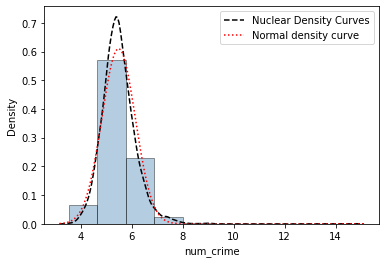

In [39]:
#draw Nuclear Density Curves and Normal density curve to judge normal distribution
from scipy import stats
sns.distplot(a=lsoa.num_crime, bins=10, fit=stats.norm, norm_hist=True,
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'label':'Nuclear Density Curves'},
             fit_kws={'color':'red', 'linestyle':':', 'label':'Normal density curve'})

plt.legend()

plt.show()


In [40]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Independent variable
X = sm.add_constant(lsoa.loc[:,['IMD_index','Income','Education','Health','Environmrnt','num_cs','p_density']])

#Constructs an empty data frame for storing VIF values
vif = pd.DataFrame()
vif['features'] = X.columns
vif['VIF Faxtor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#Return the value of VIF
print(vif)


      features  VIF Faxtor
0        const   24.376503
1    IMD_index   10.202799
2       Income    5.456539
3    Education    2.742401
4       Health    3.086921
5  Environmrnt    1.724185
6       num_cs    1.097744
7    p_density    1.363690


In [41]:
lsoa=lsoa.drop('IMD_index', axis=1) 
lsoa.columns

Index(['LSOA11CD', 'Income', 'Education', 'Health', 'Environmrnt', 'geometry',
       'num_cs', 'num_crime', 'p_density'],
      dtype='object')

In [42]:
c=lsoa.corr()
c.style.background_gradient(cmap='hot')

In [43]:
db_geo = gpd.GeoDataFrame(lsoa, geometry='geometry')
db_geo.to_file(driver='ESRI Shapefile', filename='data/lsoa_IMD_crme.shp')

Error in sys.excepthook:
Traceback (most recent call last):
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\interactiveshell.py", line 1934, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'UnicodeDecodeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\interactiveshell.py", line 1936, in showtraceback
    stb = self.InteractiveTB.structured_traceback(etype,
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\ultratb.py", line 1105, in structured_traceback
    return FormattedTB.structured_traceback(
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\ultratb.py", line 999, in structured_traceback
    return VerboseTB.structured_traceback(
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\c

In [44]:
gdf=gpd.read_file('data/lsoa_IMD_crme.shp')
gdf.head()

Error in sys.excepthook:
Traceback (most recent call last):
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\interactiveshell.py", line 1934, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'UnicodeDecodeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\interactiveshell.py", line 1936, in showtraceback
    stb = self.InteractiveTB.structured_traceback(etype,
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\ultratb.py", line 1105, in structured_traceback
    return FormattedTB.structured_traceback(
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\core\ultratb.py", line 999, in structured_traceback
    return VerboseTB.structured_traceback(
  File "C:\Users\ldy\anaconda3\envs\msda2021\lib\site-packages\IPython\c

LSOA11CD  Income  Education  Health  Environmrn  num_cs  num_crime  \
0  E01000001     0.0        0.0    -1.7        31.9      12   5.568147   
1  E01000002     0.0        0.1    -1.1        23.1      26   6.057278   
2  E01000003     0.1        5.8    -0.1        40.5       4   5.518109   
3  E01000005     0.2       22.3    -0.1        29.0      22   6.571636   
4  E01000006     0.1       14.8    -0.4        26.9       0   5.332719   

   p_density                                           geometry  
0    11656.0  POLYGON ((532105.330 182017.386, 532162.728 18...  
1     6664.0  POLYGON ((532747.048 181793.042, 532671.921 18...  
2    23198.0  POLYGON ((532135.385 182204.275, 532158.489 18...  
3     7152.0  POLYGON ((533808.170 180773.910, 533649.287 18...  
4    12613.0  POLYGON ((545122.084 184321.013, 545271.951 18...

In [45]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   LSOA11CD    4835 non-null   object  
 1   Income      4835 non-null   float64 
 2   Education   4835 non-null   float64 
 3   Health      4835 non-null   float64 
 4   Environmrn  4835 non-null   float64 
 5   num_cs      4835 non-null   int64   
 6   num_crime   4835 non-null   float64 
 7   p_density   4835 non-null   float64 
 8   geometry    4835 non-null   geometry
dtypes: float64(6), geometry(1), int64(1), object(1)
memory usage: 340.1+ KB


In [46]:
import statsmodels.api as sm

x = ['Income','Education','Health','Environmrn','num_cs','p_density'] # define input/independant variables
X = gdf.loc[:, x].values
#X = sm.add_constant(X) #add an intercept to model
print(type(X))
y = np.array(gdf['num_crime']) # dependant variable
# train model
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'numpy.ndarray'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          2.035e+04
Date:                Sun, 24 Apr 2022   Prob (F-statistic):                        0.00
Time:                        13:30:22   Log-Likelihood:                         -7224.4
No. Observations:                4835   AIC:                                  1.446e+04
Df Residuals:                    4829   BIC:                                  1.450e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            11.0515      0.286     38.626      0.000      10.491      11.612
x2             0.0498      0.002     24.195      0.000       0.046       0.054
x3            -1.4312      0.024    -59.726      0.000      -1.478      -1.384
x4             0.0840      0.001     63.974      0.000       0.081       0.087
x5             0.0385      0.003     15.045      0.000       0.033       0.044
x6          4.996e-06   2.76e-06      1.807      0.071   -4.23e-07    1.04e-05
==============================================================================
Omnibus:                      131.416   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.967
Skew:                          -0.287   Prob(JB):                     3.40e-42
Kurtosis:                       3.786   Cond. No.                     2.20e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
X

array([[ 0.0000e+00,  0.0000e+00, -1.7000e+00,  3.1900e+01,  1.2000e+01,
         1.1656e+04],
       [ 0.0000e+00,  1.0000e-01, -1.1000e+00,  2.3100e+01,  2.6000e+01,
         6.6640e+03],
       [ 1.0000e-01,  5.8000e+00, -1.0000e-01,  4.0500e+01,  4.0000e+00,
         2.3198e+04],
       ...,
       [ 2.0000e-01,  1.7900e+01,  9.0000e-01,  1.4200e+01,  0.0000e+00,
         1.2979e+04],
       [ 2.0000e-01,  9.8000e+00, -2.0000e-01,  1.4800e+01,  0.0000e+00,
         3.5500e+03],
       [ 1.0000e-01,  6.4000e+00, -4.0000e-01,  4.5700e+01,  1.0000e+00,
         1.0850e+04]])

<AxesSubplot:>

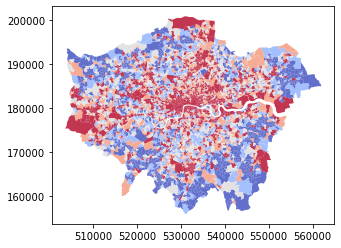

In [48]:
gdf.plot(column='num_crime', alpha=0.8, cmap='coolwarm', scheme='quantiles')

In [49]:
gdf.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

# local Moran I

In [50]:
w_queen = Queen.from_dataframe(gdf)
#w_queen.n

In [51]:
print ('%.4f'%w_queen.pct_nonzero)

0.1227


In [52]:
w_queen.histogram # frequency of n neighbors 

[(1, 2),
 (2, 21),
 (3, 170),
 (4, 636),
 (5, 1186),
 (6, 1308),
 (7, 806),
 (8, 404),
 (9, 190),
 (10, 65),
 (11, 18),
 (12, 15),
 (13, 9),
 (14, 2),
 (15, 3)]

In [53]:
# Row standardize the matrix
w_queen.transform = 'R'
w_queen[4614]

{896: 0.16666666666666666,
 4675: 0.16666666666666666,
 900: 0.16666666666666666,
 901: 0.16666666666666666,
 4613: 0.16666666666666666,
 4612: 0.16666666666666666}

In [54]:
wqmatrix, ids = w_queen.full()
wqmatrix

array([[0.  , 0.2 , 0.2 , ..., 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.25, ..., 0.  , 0.  , 0.  ],
       [0.2 , 0.2 , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [55]:
# get the spatial lag for listing price using queen weight
gdf['w_crime'] = lps.weights.lag_spatial(w_queen, gdf['num_crime'])


In [56]:
crime_Lag = lps.weights.lag_spatial(w_queen, gdf['num_crime']) #spatial lag of the variable
crime_LagQ5 = mapclassify.Quantiles(crime_Lag, k=5) # let's say k=5 for example

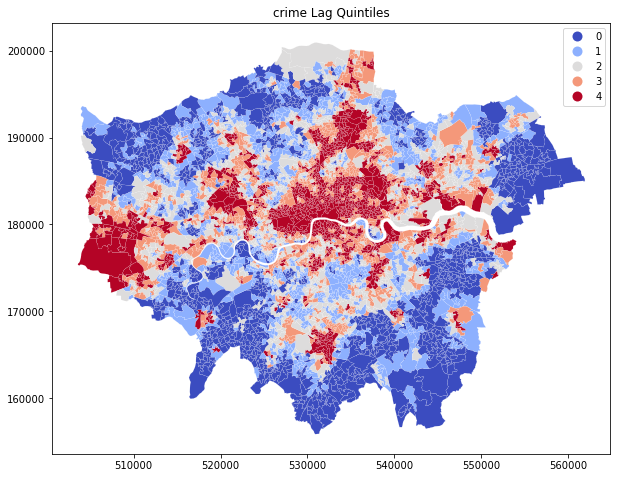

In [57]:
f, ax = plt.subplots(1, figsize=(10, 8))
gdf.assign(cl_lag=crime_LagQ5.yb).plot(column='cl_lag', categorical=True, k=5, cmap='coolwarm', linewidth=0.1, ax=ax, edgecolor='white', legend=True)
plt.title('crime Lag Quintiles')
plt.show()

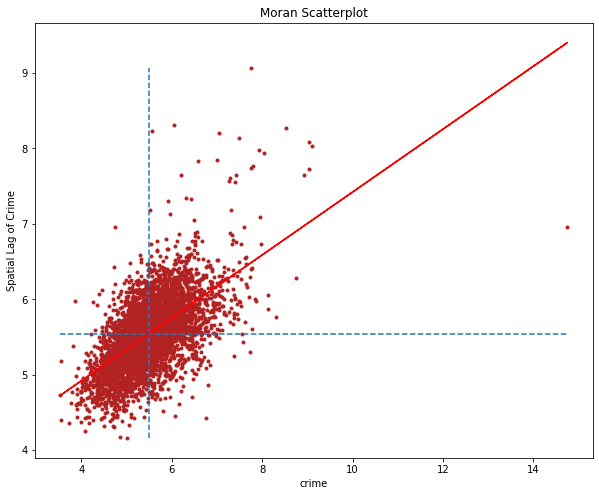

In [58]:
crime=gdf['num_crime']
b,a = np.polyfit(crime, crime_Lag, 1)
f, ax = plt.subplots(1, figsize=(10, 8))
plt.plot(crime, crime_Lag, '.', color='firebrick')

plt.vlines(crime.mean(), crime_Lag.min(), crime_Lag.max(), linestyle='--')
 
plt.hlines(crime_Lag.mean(), crime.min(), crime.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(crime, a + b*crime, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Crime')
plt.xlabel('crime')
plt.show()

In [59]:
import esda
lisa = esda.Moran_Local(gdf['num_crime'].values, w_queen, permutations=999)
lisa.Is

array([ 5.08735691e-01,  3.74929475e+00,  4.81622637e-02, ...,
        2.51080271e-03, -2.06757000e-02, -1.24987436e+00])

In [60]:
sigs = gdf['num_crime'][lisa.p_sim <= .05]
W_sigs = gdf['w_crime'][lisa.p_sim <= .05]
insigs = gdf['num_crime'][lisa.p_sim > .05]
W_insigs = gdf['w_crime'][lisa.p_sim > .05]

Text(0.5, 0, ' crime')

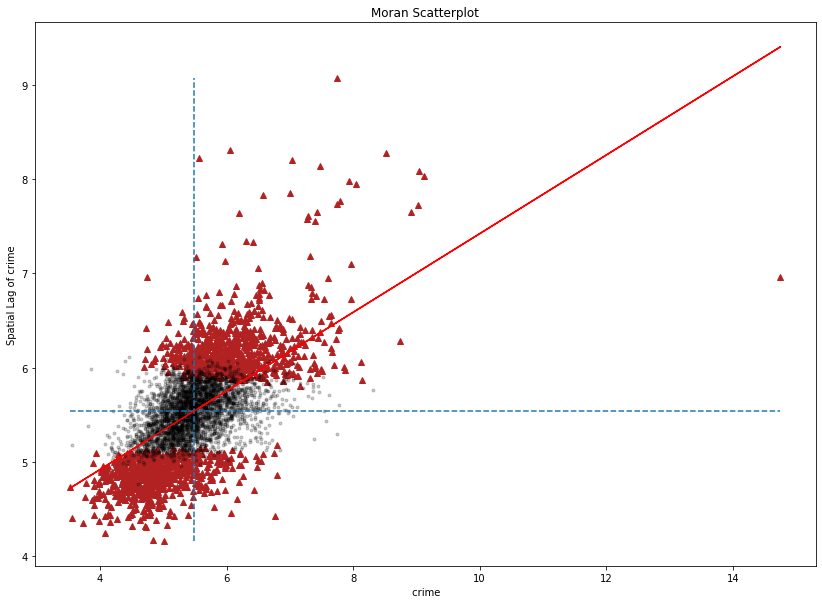

In [61]:
b,a = np.polyfit(gdf['num_crime'], gdf['w_crime'], 1)
moran=esda.Moran(gdf['num_crime'].values, w_queen)

fig, ax=plt.subplots(1, figsize=(14,10))
plt.plot(sigs, W_sigs, '^', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)

plt.vlines(gdf['num_crime'].mean(), gdf['w_crime'].min(), gdf['w_crime'].max(), linestyle='--')

plt.hlines(gdf['w_crime'].mean(), gdf['num_crime'].min(), gdf['num_crime'].max(), linestyle='--')

ax=plt.gca()
# red line of best fit using global I as slope
plt.plot(gdf['num_crime'], a + b*gdf['num_crime'], 'r')
#plt.text(s='$I = %.3f$' % moran.I, x=1400, y=500, fontsize=14,transform=ax.transAxes)
#plt.text(600, 500, "HH", fontsize=15, color='r',transform=ax.transAxes)
#plt.text(600, 0, "HL", fontsize=15, color='r',transform=ax.transAxes)
#plt.text(50, 500, "LH", fontsize=15, color='b',transform=ax.transAxes)
#plt.text(50, 0, "LL", fontsize=15, color='b',transform=ax.transAxes)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of crime')
plt.xlabel(' crime')

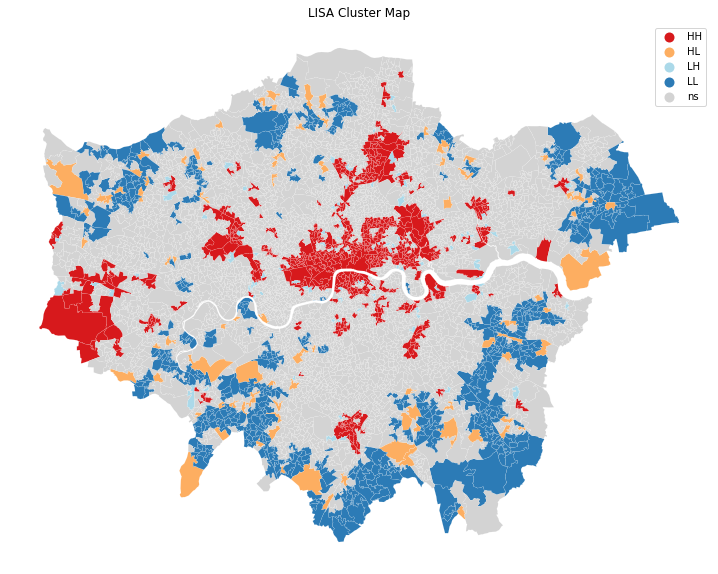

In [62]:
from splot.esda import lisa_cluster
fig, ax=plt.subplots(1, figsize=(14,10))
fig = lisa_cluster(lisa, gdf, ax=ax)
plt.title("LISA Cluster Map")
plt.show()

# OSL

In [63]:
# read the .dbf file 
f = lps.io.open('data/lsoa_IMD_crme.dbf','r')
# Read in the dependent variable into an array y
y = np.array(f.by_col['num_crime'])
y.shape = (len(y),1)

X= []

X.append(f.by_col['Income']) 
X.append(f.by_col['Education']) 
X.append(f.by_col['Health'])
X.append(f.by_col['Environmrn']) 
X.append(f.by_col['num_cs']) 
X.append(f.by_col['p_density']) 
X = np.array(X).T

In [64]:
spat_lag = OLS(y,X,w_queen,name_y='crime', 
                  name_x=['Income','Education','Health','Environmrn','num_cs','p_density'],
                  name_w='w_queen', name_ds='lsoa_crime')
print(spat_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :  lsoa_crime
Weights matrix      :     w_queen
Dependent Variable  :       crime                Number of Observations:        4835
Mean dependent var  :      5.4887                Number of Variables   :           7
S.D. dependent var  :      0.6536                Degrees of Freedom    :        4828
R-squared           :      0.5070
Adjusted R-squared  :      0.5064
Sum squared residual:    1018.260                F-statistic           :    827.3967
Sigma-square        :       0.211                Prob(F-statistic)     :           0
S.E. of regression  :       0.459                Log likelihood        :   -3094.621
Sigma-square ML     :       0.211                Akaike info criterion :    6203.242
S.E of regression ML:      0.4589                Schwarz criterion     :    6248.628

-----------------------------------------------------------------------------

# GWR

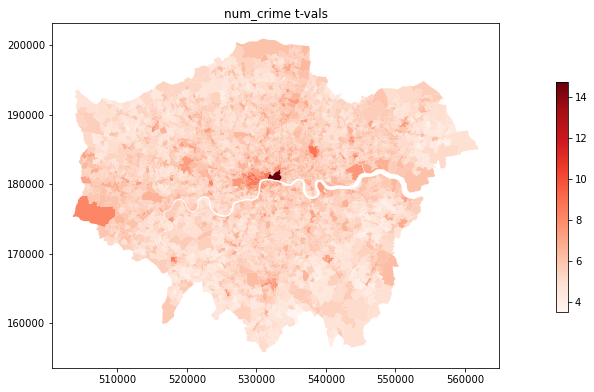

In [65]:
#original
vmin, vmax = np.min(gdf['num_crime']), np.max(gdf['num_crime']) 
ax = gdf.plot('num_crime', vmin=vmin, vmax=vmax, figsize=(8,8), cmap='Reds')
ax.set_title('num_crime'+' t-vals')
fig = ax.get_figure()
cax = fig.add_axes([1.0, 0.3, 0.02, 0.4]) 
sm_price = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Reds')
sm_price._A = []
fig.colorbar(sm_price, cax=cax)

In [66]:
# Prep data into design matrix and coordinates

# Dependent variable
y = gdf['num_crime']
y = np.array(y).reshape(-1,1) 

In [67]:
#Design matrix - covariates - intercept added automatically

Income = np.array(gdf.Income).reshape(-1,1)
Education = np.array(gdf.Education).reshape(-1,1)
Health = np.array(gdf.Health).reshape(-1,1)
Environmrn = np.array(gdf.Environmrn).reshape(-1,1)
num_cs = np.array(gdf.num_cs).reshape(-1,1)
p_density = np.array(gdf['p_density']).reshape(-1,1)

X = np.hstack([Income,Education,Health,Environmrn,num_cs,p_density])
labels = ['Intercept','Income','Education','Health','Environmrn','num_cs','p_density']

# standardization
X_s = (X - X.mean(axis=0)) / X.std(axis=0)
y_s = (y - y.mean(axis=0)) / y.std(axis=0)

In [68]:
#Coordinates for calibration points
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = gdf['geometry'].centroid
u,v = [list(t) for t in zip(*map(getXY, centroidseries))]

coords = list(zip(u,v))

In [69]:
#Prepare dataset inputs
g_y = gdf['num_crime'].values.reshape((-1,1))
g_X = gdf[['Income','Education','Health','Environmrn','num_cs','p_density']].values

g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [70]:
from mgwr.sel_bw import Sel_BW

# Select bandwidth for kernel
bw = Sel_BW(g_coords, 
            g_y, # Independent variable
            g_X, # Dependent variable
            fixed=False, # True for fixed bandwidth and false for adaptive bandwidth
            spherical=True) # Spherical coordinates (long-lat) or projected coordinates
# calculate the optimum bandwidth for our local regression
bw.search(bw_min=2)

342.0

In [71]:
from mgwr.gwr import GWR
#Instantiate GWR model and then estimate parameters and diagnostics using fit method
model = GWR(coords, y, X, bw.bw[0])
results = model.fit()

In [72]:
#Results in a set of mappable results 
results.params.shape

(4835, 7)

In [73]:
results.params

array([[ 5.75426153e+00, -1.65903396e-01,  5.03157806e-03, ...,
         8.24313331e-03,  3.39888410e-02, -2.30908302e-05],
       [ 5.66153819e+00,  1.54980000e-01,  4.58507310e-03, ...,
         8.89741058e-03,  3.51117774e-02, -2.21355418e-05],
       [ 5.72120320e+00, -2.79893345e-02,  3.04841067e-03, ...,
         7.98603874e-03,  3.45332276e-02, -2.09061061e-05],
       ...,
       [ 5.04772583e+00,  2.20117700e+00, -8.57576040e-03, ...,
         1.25331668e-02,  1.46966165e-01, -1.58793629e-05],
       [ 5.03758772e+00,  3.20046971e+00, -1.72568490e-02, ...,
         1.54541473e-02,  1.53560117e-01, -2.16423559e-05],
       [ 4.99482201e+00,  1.84760869e+00,  2.70761698e-03, ...,
         1.12662129e-02,  4.03275212e-02, -1.25351579e-05]])

In [74]:
print (results.bse[0:10, 1])
print (results.tvalues[0:10, 1])

[0.54983222 0.54699356 0.57113332 0.52602251 0.64188189 0.63741854
 0.62173783 0.64500899 0.6305534  0.64430531]
[-0.30173459  0.28333058 -0.04900666  2.77891959  3.47757158  3.59167609
  3.56001082  3.55442125  3.56503254  3.63023461]


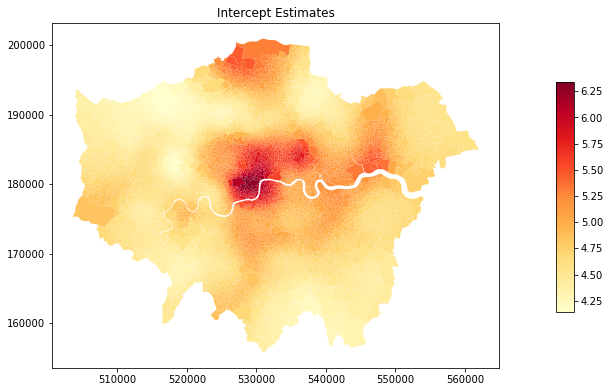

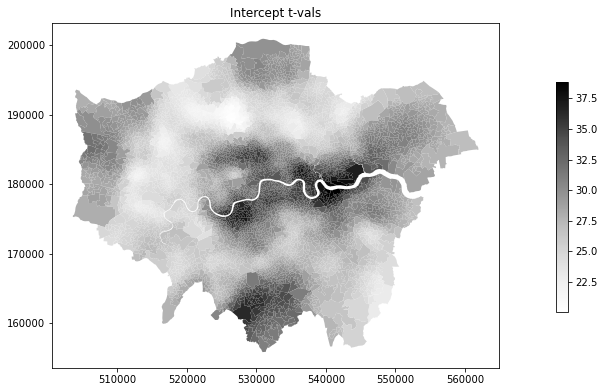

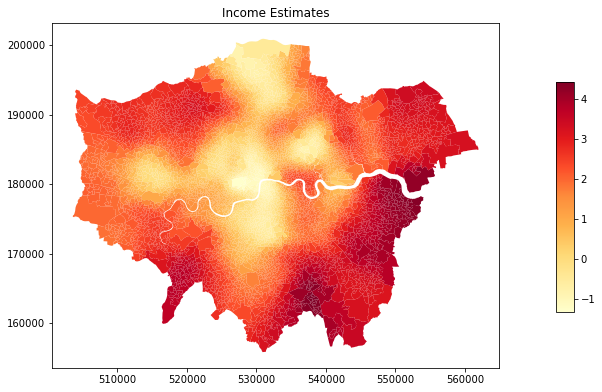

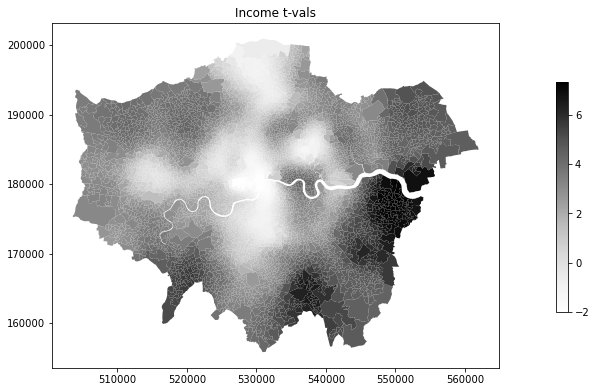

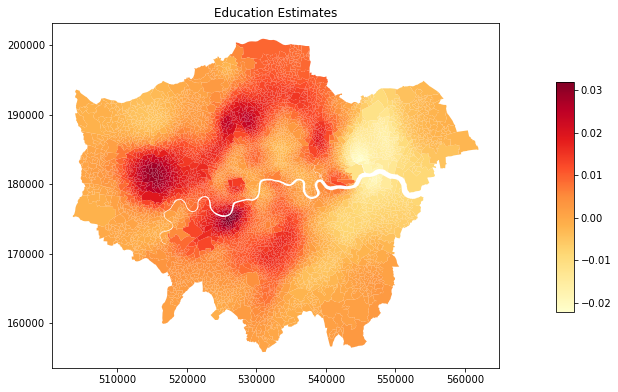

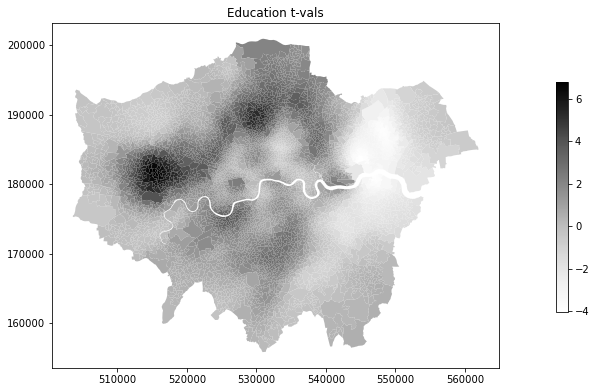

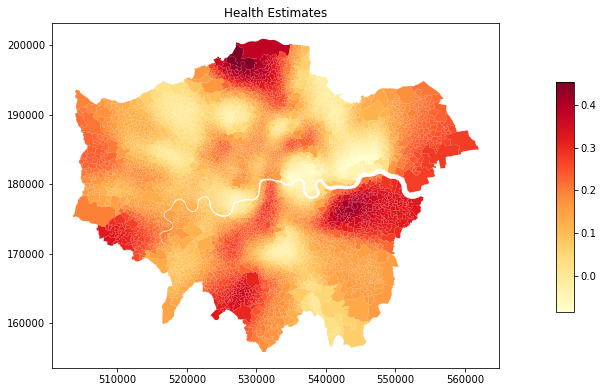

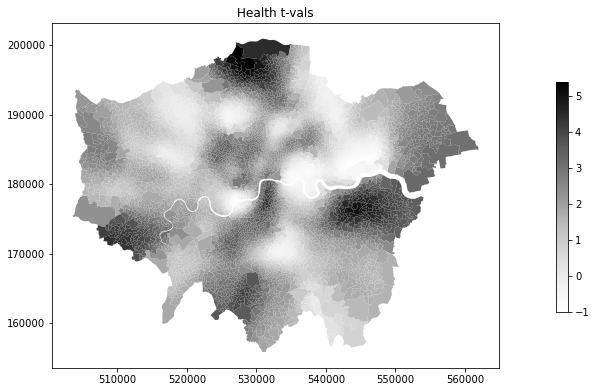

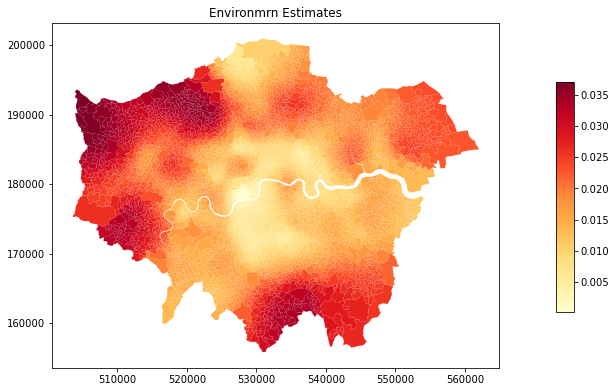

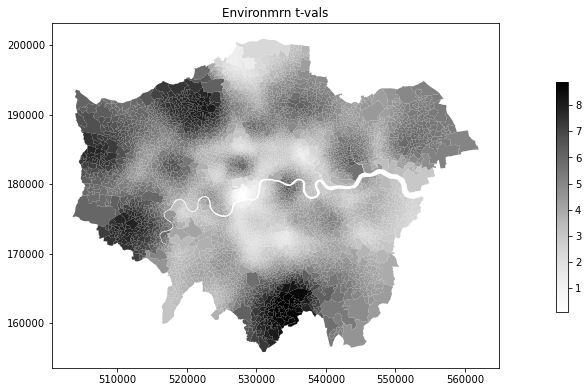

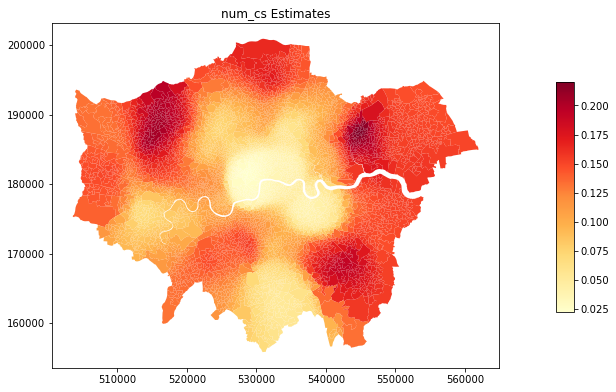

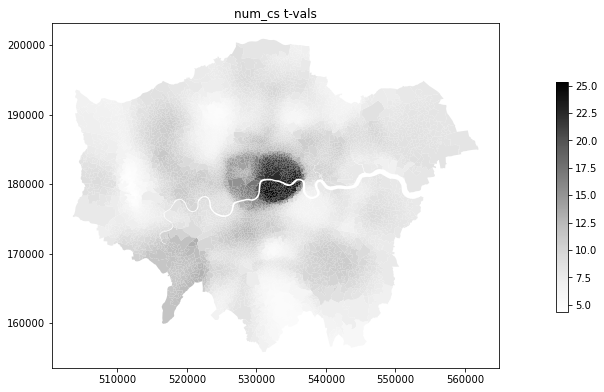

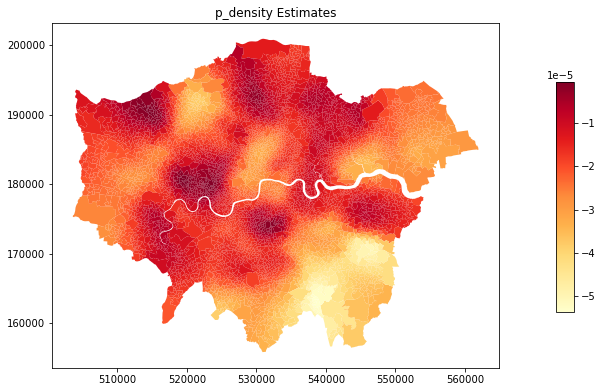

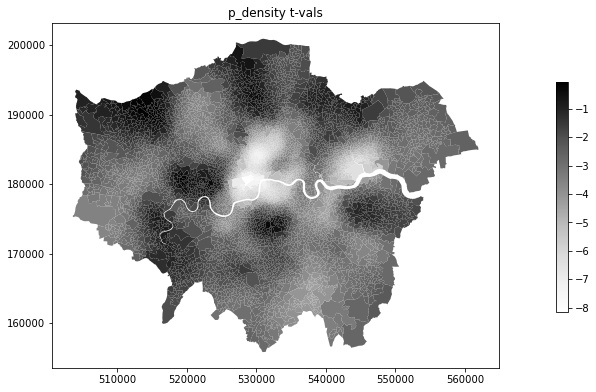

In [75]:
#Map Parameter estimates and T-vals for each covariate
for param in range(results.params.shape[1]):
    gdf[str(param)] = results.params[:,param]
    vmin, vmax = np.min(gdf[str(param)]), np.max(gdf[str(param)]) 
    ax = gdf.plot(str(param), vmin=vmin, vmax=vmax, figsize=(8,8), cmap='YlOrRd')
    ax.set_title(labels[param] + ' Estimates')
    fig = ax.get_figure()
    cax = fig.add_axes([1.0, 0.3, 0.03, 0.4])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='YlOrRd')
    sm._A = []
    fig.colorbar(sm, cax=cax)
    
    gdf[str(param)] = results.tvalues[:,param]
    vmin, vmax = np.min(gdf[str(param)]), np.max(gdf[str(param)]) 
    ax = gdf.plot(str(param), vmin=vmin, vmax=vmax, figsize=(8,8), cmap='Greys')
    ax.set_title(labels[param] + ' t-vals')
    fig = ax.get_figure()
    cax = fig.add_axes([1.0, 0.3, 0.02, 0.4])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Greys')
    sm._A = []
    fig.colorbar(sm, cax=cax)

In [76]:
print (len(results.localR2))
print (np.mean(results.localR2))
print (results.localR2)

4835
0.558652046674706
[[0.86155699]
 [0.8614436 ]
 [0.85389672]
 ...
 [0.5793737 ]
 [0.64256227]
 [0.38066736]]


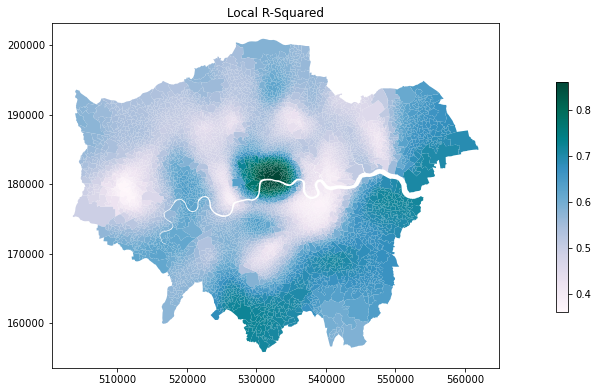

In [77]:
#Map local R-square values which is a weighted R-square at each observation location

gdf['localR2'] = results.localR2
vmin, vmax = np.min(gdf['localR2']), np.max(gdf['localR2']) 
ax = gdf.plot('localR2', vmin=vmin, vmax=vmax, figsize=(8,8), cmap='PuBuGn')
ax.set_title('Local R-Squared')
fig = ax.get_figure()
cax = fig.add_axes([1.0, 0.3, 0.02, 0.4])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='PuBuGn')
sm._A = []
fig.colorbar(sm, cax=cax)